In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_astradb import AstraDBVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain import hub
from langchain.schema import Document
from langgraph.graph import START, StateGraph, END
from typing import Literal, List
from typing_extensions import TypedDict
from dotenv import load_dotenv
import os

c:\a\envs\law\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
ASTRA_API_KEY = os.getenv("ASTRA_API_KEY")
DB_ENDPOINT = os.getenv("DB_ENDPOINT")
DB_ID = os.getenv("DB_ID")

In [161]:
llm = ChatGoogleGenerativeAI(api_key = GOOGLE_API_KEY, model = "gemini-1.5-flash",temperature = 1)
print(llm.invoke("What is capital of India").content)

The capital of India is **New Delhi**. 



In [4]:
def pdf_2_document(data):
    loader = DirectoryLoader(glob = "*.pdf", loader_cls = PyPDFLoader, path = data)
    docs = loader.load()
    return docs

In [5]:
docs = pdf_2_document("data/")

In [6]:
def text_2_chunks(docs):
    splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 100)
    chunks = splitter.split_documents(docs)
    return chunks

In [7]:
chunks = text_2_chunks(docs)
len(chunks)

2306

Data Ingestion Process

In [4]:
gemini_embedding = GoogleGenerativeAIEmbeddings(google_api_key = GOOGLE_API_KEY, model = "models/embedding-001")

In [11]:
def ingest(status):
    vector_store = AstraDBVectorStore(embedding = gemini_embedding,
                                      api_endpoint = DB_ENDPOINT,
                                      namespace = "constitution",
                                      token = ASTRA_API_KEY,
                                      collection_name = "Law_bot")
    
    if status == None:
        len = vector_store.add_documents(chunks)
        return vector_store
    else:
        return vector_store

In [12]:
vector_store = ingest("done")#CHANGE THIS THE PARAMETER TO NONE I ALREADY RAN THIS CELL HENCE IT IS "done",
print("Data Ingested Successfully")

Data Ingested Successfully


In [12]:
vector_store.similarity_search("I had a argument with Police could You tell me what to do according to the indian constituion")

[Document(metadata={'source': 'data\\Constitution.pdf', 'page': 41}, page_content='THE CONSTITUTION OF  INDIA\n(Part III.—Fundamental Rights)11\n(6) Nothing in sub-clause ( g) of the said clause shall affect the operation \nof any existing law in so far as it imposes, or prevent the State from making \nany law imposing, in the interests of the general public, reasonable restrictions \non the exercise of the right conferred by the said sub-clause, and, in particular, \n1[nothing in the said sub-clause shall affect the operation of any existing law in'),
 Document(metadata={'source': 'data\\Constitution.pdf', 'page': 43}, page_content='THE CONSTITUTION OF  INDIA\n(Part III.—Fundamental Rights)13\nProvided that nothing in this sub-clause shall authorise the detention \nof any person beyond the maximum period prescribed by any law made \nby Parliament under sub-clause ( b) of clause (7); or\n(b) such person is detained in accordance with the provisions of any \nlaw made by Parliament under

In [5]:
vector_store = AstraDBVectorStore(embedding = gemini_embedding,
                                      api_endpoint = DB_ENDPOINT,
                                      namespace = "constitution",
                                      token = ASTRA_API_KEY,
                                      collection_name = "Law_bot")

In [6]:
retriver = vector_store.as_retriever()

In [7]:
class GraphState(TypedDict):
    question : str
    documents : List[str]
    generation : str   
    route : str

In [8]:
def route(state : GraphState) -> str:
    question = state["question"]

    class RouteQuery(BaseModel):
        datasource: Literal["vectorstore", "out_of_context"] = Field(..., description = "For a given User Question find out whether to route it to vectorstore or out_of_context.")

    system = """You are an expert at routing a user question to a vectorstore or out_of_context.
    The vectorstore contains documents of The Constitution of India. NOTE: if any question has the words 'according to Indian Constitution' use 'vectorstore'.
    Use the vectorstore for questions on these topics. Otherwise, use out_of_context."""

    llm_router = llm.with_structured_output(RouteQuery)

    route_prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
    question_router = route_prompt | llm_router
    response = question_router.invoke({"question": question})
    
    return response.datasource

In [226]:
def Grade_Docs(state : GraphState) -> str:
    # docs = state["documents"]
    question = state["question"]
    print(question)
    docs = retriver.get_relevant_documents(question)
    print("Docs are available")
    class Grading(BaseModel):
        binary_source: Literal["yes", "no"] = Field(..., description = "Documents are relevant to question, Yes or no")
    
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")])

    llm_grader = llm.with_structured_output(Grading)
    retrieval_grader = grade_prompt | llm_grader
    
    response = retrieval_grader.invoke({"question": question, "document": docs})
    print(response)
    # return response.binary_source
    state["documents"] = docs
    return {"binary_source": response.binary_source}

In [227]:
load_dotenv()
LANGCHAIN_TRACING_V2= True
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT="Law-Bot"

In [306]:
def retrieve(state : GraphState):
    question = state["question"]

    prompt = hub.pull("rlm/rag-prompt",api_key=LANGCHAIN_API_KEY)
    
    rag_chain = prompt | llm | StrOutputParser()

    docs = retriver.get_relevant_documents(question)
    generation = rag_chain.invoke({"context" : docs,"question" : question})
    # print(generation)

    state["generation"] = generation
    state["documents"] = docs
    # print(state["generation"])
    return generation

In [307]:
def decide_to_generate(state: GraphState):
    question = state["question"]
    generation = state["generation"]

    class Decide(BaseModel):
        binary_score: Literal["Yes", "No"] = Field(..., description="Answer should be generated or not, yes or no.")

    llm_decide = llm.with_structured_output(Decide)

    system = """You are an expert in deciding whether an answer to a given question should be generated or not.
                If you think that the generated answer resolves the query, answer 'Yes', otherwise answer 'No'.
                question: {question} answer:{generation}"""
    
    decide_prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "question:{question}\n answer: {generation}")])

    decide = decide_prompt | llm_decide

    response = decide.invoke({"question": question, "answer": generation})

    # return response.binary_score
    if isinstance(response, dict):
        return response
    else:
        # Wrap response in a dict with the key 'binary_score'
        return {"binary_score": response}
    

In [308]:
def transform_query(state:GraphState):
    question = state["question"]

    system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""


    rewrite_prompt = ChatPromptTemplate([("system",system),("human","Here is the initial question:\n{question} formulate only one improved question")])

    question_rewriter = rewrite_prompt | llm | StrOutputParser()
    question_rewriter.invoke({"question": question})

    better_question = question_rewriter.invoke({"question":question})

    state["question"] = better_question


In [309]:
def out_of_context(state):
    print("THE QUESTION IS OUT OF CONTEXT FOR THE INDIAN CONSTITUTION.")

In [310]:
def result(state):
    generation = state["generation"]
    print(f"BOT:\n{generation}")

MAKING THE GRAPH COMPRISING OF ALL THE NODES AND EDGES

In [311]:
workflow = StateGraph(GraphState)

workflow.add_node("out_of_context_node", out_of_context)
# workflow.add_node("doc_dec_node",Grade_Docs)
workflow.add_node("retrieve_node", retrieve)
# workflow.add_node("grade_docs_node", Grade_Docs)
workflow.add_node("transform_query_node", transform_query)
workflow.add_node("result_node", result)

# Adding conditional edges with correct conditions
workflow.add_conditional_edges(START, route,{
    "vectorstore": "retrieve_node",
    "out_of_context": "out_of_context_node"
})

workflow.add_edge("out_of_context_node", END)

workflow.add_conditional_edges("retrieve_node", decide_to_generate,{
    "yes": "result_node",
    "no": "transform_query_node"
})

workflow.add_edge("transform_query_node","retrieve_node")


workflow.add_edge("result_node",END)

app = workflow.compile()


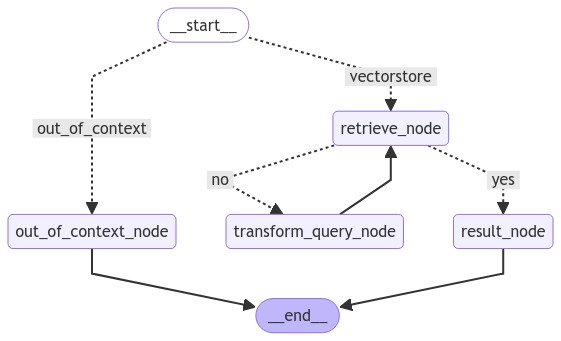

In [312]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [322]:
import pprint

# Define the inputs as a dictionary
inputs = {"question": "Which article dicusses about women rights in indian constitution?"}

# Run the workflow
try:
    for output in app.stream(inputs):
        # Print the complete output to inspect its structure
        print("Complete Output:")
        pprint.pprint(output)

        # Check if output is iterable (e.g., a list or dictionary)
        if isinstance(output, dict):
            for key, value in output.items():
                # Print the node name
                print(f"Node '{key}':")
                # Print the detailed output for each node
                pprint.pprint(value)
                # Optional: Print the data if available
                if 'data' in value:
                    print("Data:")
                    for sub_key, sub_value in value['data'].items():
                        print(f"  {sub_key}: {sub_value}")
                print("\n---\n")
                
                # Debugging for the 'generation' issue
                if 'generation' in value:
                    print("Generation data found:")
                    pprint.pprint(value['generation'])
                    
        elif isinstance(output, list):
            for item in output:
                # Print each item in the list
                pprint.pprint(item)
        else:
            # If it's neither a dictionary nor a list
            print(f"Unexpected output type: {type(output)}")
            print(output)

except KeyError as e:
    print(f"KeyError: {e} - Check if the key is properly updated or exists in the state.")
except Exception as e:
    response = e
    print(response)
    print(llm.invoke(f"""{response} remove "Expected dict, got" if showing and return the original statement without error .Note Do not write anything else.""").content)


Expected dict, got The provided context discusses reservations of seats for women in the House of the People and Legislative Assemblies of the States. It also mentions provisions for women and children in the Fundamental Rights section. However, the exact article discussing women's rights in the Indian Constitution is not specified in the provided context. 

The provided context discusses reservations of seats for women in the House of the People and Legislative Assemblies of the States. It also mentions provisions for women and children in the Fundamental Rights section. However, the exact article discussing women's rights in the Indian Constitution is not specified in the provided context. 

